---
# <center> Semi-Supervised Learning (SSL)
    
<center> Realized by: Eya Ghamgui  
    
<center> eya.ghamgui@telecom-paris.fr

<center> March 03, 2022
    
---

SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import os
import numpy as np
from scipy.io import loadmat
from helper import mask_labels
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from helper import plot_classification
from sklearn.preprocessing import OneHotEncoder
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized

import warnings
warnings.filterwarnings("ignore")

In [2]:
"""
Define parameters for HFS

"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = None

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'unn'

# Coefficients for C matrix for soft HFS
params['c_l'] = 0.99
params['c_u'] = 0.01

In [3]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    
    """
    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1
    
    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    
    """
    onehot = OneHotEncoder(handle_unknown='ignore')
    y = onehot.fit_transform(Y.reshape(-1,1)).toarray()
    
    # Delete the column created for the unlabeled class "0"
    y = y[:, 1:] 
    
    l_idx = np.where(Y!=0)[0]
    u_idx = np.where(Y==0)[0]
    
    if not soft:    
        """
        Compute hard HFS.  
        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """        
        l_uu = L[:,u_idx][u_idx]
        l_ul = L[:,l_idx][u_idx]    
        
        f_l = y[l_idx]
        f_u = -1 * np.linalg.pinv(l_uu) @ l_ul @ f_l 
        
        f = np.zeros((num_samples, num_classes))
        f[l_idx] = f_l
        f[u_idx] = f_u
 
    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        c_l = params['c_l']
        c_u = params['c_u']
        
        C = np.zeros(num_samples)
        C[l_idx] = c_l
        C[u_idx] = c_u
        
        C = np.diag(C)        
        f = np.linalg.pinv(np.linalg.pinv(C) @ L + np.eye(num_samples)) @ y

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f, axis=1) + 1  
    
    return labels, f

In [4]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', 
                  per_class=False, plot=True, printt= True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of "noisy" labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    per_class : bool
        If True, we select "l" labeled samples per class. Otherwise, we select "l" labeled samples in total.
    plot : bool
        If True, show plots
    printt : bool 
        If True, print the accuracy 
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l, per_class=per_class)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    L = build_laplacian_regularized(X, 
                                    laplacian_regularization = params['laplacian_regularization'], 
                                    var = params['var'], 
                                    eps = params['eps'],
                                    k = params['k'],
                                    laplacian_normalization = params['laplacian_normalization'])

    labels, f = compute_hfs(L, Y_masked, soft, **params)
    accuracy = np.mean(labels == np.squeeze(Y))

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    
    if printt:
        print(f"Soft={soft}, Accuracy={accuracy}")
    
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

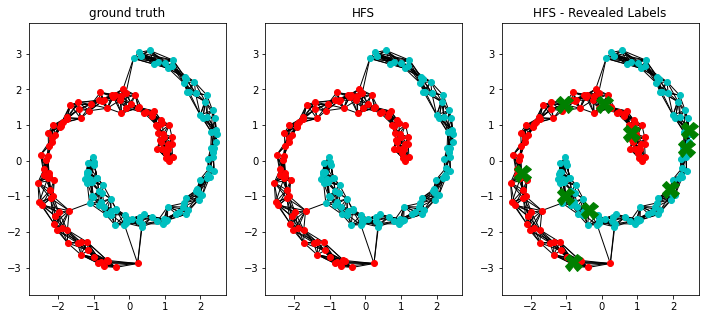

Soft=False, Accuracy=1.0


In [5]:
# Construct a connected graph 
params['k'] = 10
params['laplacian_normalization'] = 'unn'

# Apply HFS to two-moons dataset
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, 
                                                 dataset='data_2moons_hfs.mat', plot=True, seed=42, **params)

**Answer:**

> In this question, we performed the Hard HFS method using a k-nn graph and a Laplacian matrix $L_{unn}$ without regularization. By changing the value of $k$ of the k-nn graph to $10$, we found that HFS with $l=10$ and $l_{noisy} =0$ gives an accuracy of $100 \%$. 
<br><br>
$\Longrightarrow$ We can conclude that this method is able to correctly classify all unlabeled samples. 

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

Trial 1:


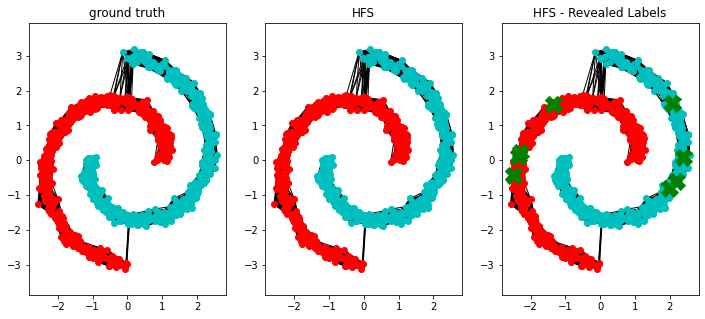

Soft=False, Accuracy=1.0

Hard HFS: 
Mean of accuracy: 1.0
Variance of accuracy: 0.0


In [6]:
# Construct a connected graph 
params['k'] = 45 
params['laplacian_normalization'] = 'unn'
accuracy = []

# Apply HFS to large two-moons dataset 20 times 
for ii in range(20):
    if ii > 0 : 
        plot = False
    else: 
        print('Trial '+str(ii+1)+':')
        plot= True 
        
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                     dataset='data_2moons_hfs_large.mat', plot=plot,
                                                     printt = plot, per_class=True, seed=None, **params)
    accuracy.append(hard_accuracy)
    
print()
print('Hard HFS: ')
print('Mean of accuracy:' ,np.mean(accuracy))
print('Variance of accuracy:' ,np.var(accuracy))

**Answer:** 

> - With $l=4$, we notice that running the algorithm several times often leads to error. Indeed, by selecting only four labeled samples among $1000$ for a two-class problem, it is more probable to obtain the four selected points of the same class in at least one of the $20$ successive iterations. Thus, this would lead to the resulted error.  <br><br>
> - By increasing the number of selected points, we increase the probability of having different classes. Thus, by using the option: <br> **per_class = True**, which means taking the same number $l$ of labeled samples per class instead of $l$ labels in total, we can guarantee to have all classes in the selected labeled samples.
<br><br>
> - By changing the parameters of the graph, we selected $k=45$ to ensure the connectivity of the graph and the Laplacian matrix $L_{unn}$ without regularization. Therefore, we obtained an accuracy of $100\%$ for all the $20$ trials. By plotting the clustered samples from the first iteration, we found that the algorithm correctly classifies both classes. 
<br><br>
> $\Longrightarrow$ We can conclude that even when using a larger data set, we still obtain an accuracy of $100\%$.  

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

- **First case: data_2moons_hfs**

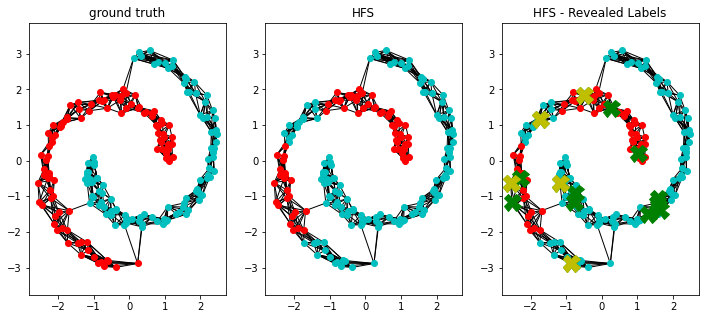

Soft=False, Accuracy=0.855


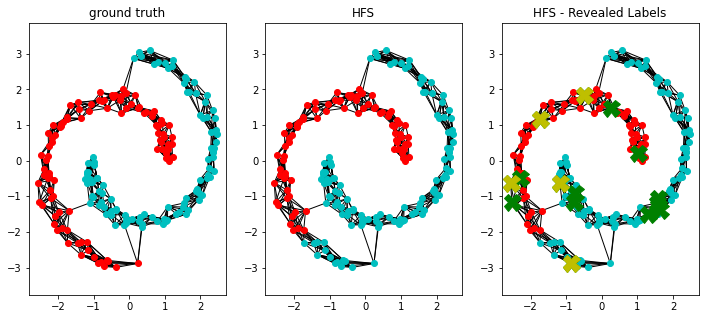

Soft=True, Accuracy=0.93

Repeating the experiment 20 times: 

- Hard HFS: 
Mean of accuracy: 0.8095
Variance of accuracy: 0.0143
- Soft HFS: 
Mean of accuracy: 0.9005
Variance of accuracy: 0.0109


In [7]:
################################
# Comparing hard HFS to soft HFS
################################

# Choose parameters 
seed = 5  
plot = True 
dataset = 'data_2moons_hfs.mat' 
params['k'] = 10
params['laplacian_normalization'] = 'unn'

# Apply HFS once and plot the results 
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
print()

# Choose parameters 
seed = None
plot = False
hard_acc = []
soft_acc = []

# Apply HFS several times 
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                     plot=plot, seed=seed, **params , printt = False)

    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                     plot=plot, seed=seed, **params , printt = False)
    
    hard_acc.append(hard_accuracy)
    soft_acc.append(soft_accuracy)
    
# Report the average and variance of the accuracy
print('Repeating the experiment 20 times: ')
print()
print('- Hard HFS: ')
print('Mean of accuracy:' ,round(np.mean(hard_acc),4))
print('Variance of accuracy:' ,round(np.var(hard_acc),4))
print('- Soft HFS: ')
print('Mean of accuracy:' ,round(np.mean(soft_acc),4))
print('Variance of accuracy:' ,round(np.var(soft_acc),4))

- **Second case: data_2moons_hfs_large**

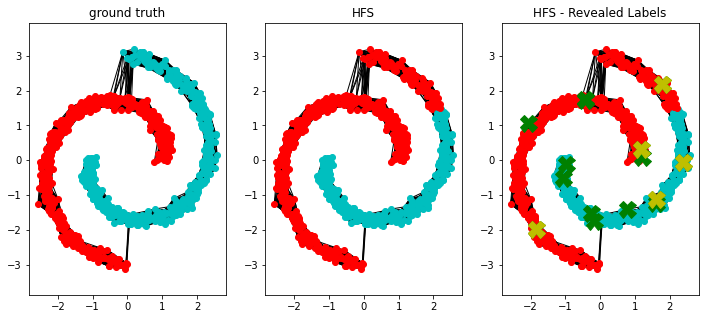

Soft=False, Accuracy=0.897


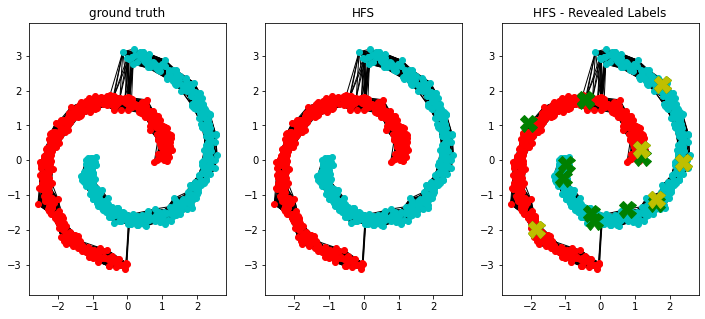

Soft=True, Accuracy=1.0

Repeating the experiment 20 times: 

- Hard HFS: 
Mean of accuracy: 0.9872
Variance of accuracy: 0.0005
- Soft HFS: 
Mean of accuracy: 1.0
Variance of accuracy: 0.0


In [8]:
################################
# Comparing hard HFS to soft HFS
################################

# Choose parameters 
seed = 5  
plot = True 
dataset = 'data_2moons_hfs_large.mat'
params['k'] = 45
params['laplacian_normalization'] = 'unn'

# Apply HFS once and plot the results 
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
print()

# Choose parameters 
seed = None
plot = False
hard_acc = []
soft_acc = []

# Apply HFS several times 
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                     plot=plot, seed=seed, **params , per_class=True , printt = False)

    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                     plot=plot, seed=seed, **params , per_class=True ,printt = False)
    
    hard_acc.append(hard_accuracy)
    soft_acc.append(soft_accuracy)
    
# Report the average and variance of the accuracy
print('Repeating the experiment 20 times: ')
print()
print('- Hard HFS: ')
print('Mean of accuracy:' ,round(np.mean(hard_acc),4))
print('Variance of accuracy:' ,round(np.var(hard_acc),4))
print('- Soft HFS: ')
print('Mean of accuracy:' ,round(np.mean(soft_acc),4))
print('Variance of accuracy:' ,round(np.var(soft_acc),4))

**Answer:** 

> - In this question, we performed both Soft and Hard HFS to study their performance. We chose the previous values of $k$ to ensure the connectivity of the graphs. In addition, we used $c_l = 0.99$ and $c_u = 0.01$ to make sure that labeled samples are more important than unlabeled ones in the case of Soft HFS.
<br><br> 
> - For the two moons dataset, by using Soft HFS, we obtained better performance (around $93 \%$ of accuracy) while we got $85.5 \%$ of accuracy when using Hard HFS. Moreover, the clustering plot is better for Soft HFS. By trying the experiment several times, it is clear that the Soft HFS method performs better than the Hard HFS in terms of accuracy and stability (the variance of the accuracy of the Soft HFS is lower than that of the Hard HFS). In fact, when using the Hard HFS, it is more likely that the error from the noisy labels will propagate because the algorithm does not change the labels of the labeled points, only the unlabeled points will be labeled based on the noisy labels. On the other hand, the Soft HFS predicts the harmonic function of all points, even the labeled ones, which can reduce the noise effect. We can conclude that it is better to use Soft HFS to avoid propagating too much errors.
<br><br> 
> - For a larger dataset, we can say that Soft HFS still performs better than Hard HFS. The Soft HFS is able to label all samples correctly with $100 \%$ accuracy. The accuracy of the Hard HFS has also increased due to the increase in the number of samples compared to the error rate. 

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

**Answer:** 
> In order to be able to label more than two classes, I started by encoding the labels using the OneHotEncoder. With One-Hot, each class value is represented as a binary vector. All values are equal to zero, and the index of the class is marked with a $1$. In the case of an unlabeled sample, all columns will be equal to zero. Thus, the harmonic function is now in $\mathbb{R}^{N \times C}$ instead of $\mathbb{R}^{N}$ where $C$ is the number of classes and $N$ is the number of samples. Furthermore, the labels are assigned with (**index + 1**) of the class having the highest score.

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

    
**Answer:** 

> - In this question, we started by performing data preprocessing. We tried several methods for image enhancement. We started by processing the image with a bilateral filter. Then, we applied the CLHAE (Contrast Limited Adaptive Histogram Equalization) method. This method is much better than the histogram equalization method. Indeed, it is robust to facial expressions, occlusions and especially to illumination changes. CLAHE is an improved version of histogram equalization that overcomes the limitations of standard histogram equalization when the gray level distribution is very localized and it is not desirable to transform very low contrast images. After that, we applied a median filter of size $3$ on the resulted image. In fact, the median filter is better than Gaussian blur at removing noise while preserving edges.
<br><br>
> - For the small dataset, we used the Laplacian $L_{rw}$ of the k-nn graph with $k=5$. In addition, we used a regularization of the Laplacian equal to $0.05$. Finally, we found the best accuracy is equal to $86\%$. 
<br><br>
> - For the large dataset, we used the Laplacian $L_{unn}$ of the k-nn graph with $k=7$. In addition, we used a regularization of the Laplacian equal to $0.05$. Finally, we found the best accuracy is equal to $71.8\%$.

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

**Answer:** 

> - When we used a larger dataset, the accuracy decreased by $14.2 \%$. In fact, for the smaller dataset, we found that $40\%$ of the data is labeled, signifying that $4$ labeled samples among $10$ are provided per individual (almost half of the data). However, for the larger dataset, we notice that the augmented samples are not labeled. Thus, only $8\%$ of the data is labeled, which makes it difficult to classify unlabled samples given a low percentage of labels. Therefore, it is much easier for errors to propagate.
<br><br>
> - Additional data does not always increase the performance. If the added data is not labeled, it will not help the algorithm in its labeling task. However, adding labeled data would improve performance by giving additional information to the classifier. But, in case the added data is of poor quality, this may induce more errors than without these added samples.

In [9]:
import os
import cv2
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [10]:
"""
Define parameters for face recognition with HFS

"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 1.0
params_face_rec['var'] = 5000.0
params_face_rec['eps'] = None
params_face_rec['k'] = None
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = 0.95
params_face_rec['c_u'] = 0.05

In [11]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
        
    """
    output_frame_size = 96   # do not change the output frame size!
    
    # Bilateral filtering 
    image = cv2.bilateralFilter(image,3, 75,75)
    
    # Contrast Limited Adaptive Histogram Equalization method
    clahe = cv2.createCLAHE(tileGridSize=(8,8))
    image = clahe.apply(image)
    
    # Median filtering
    image = cv2.medianBlur(image,3)
    
    # Resize images 
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)
    im -= im.mean()
    im /= im.max()
    image = im
    
    return image

- **First dataset: 10 images per person**

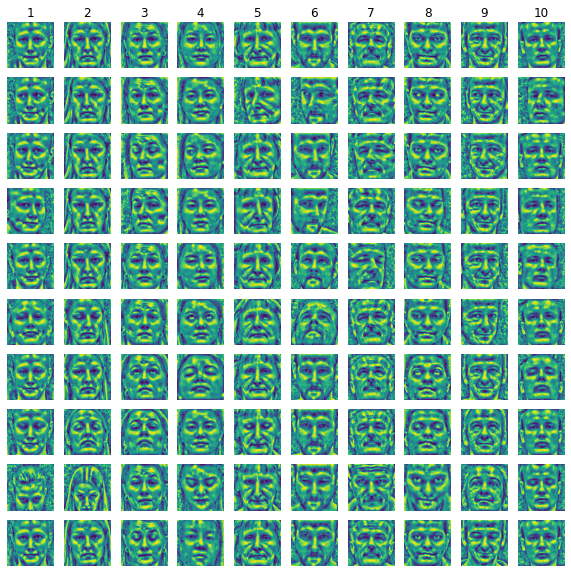

In [12]:
# 10 images per person
np.random.seed(456)  
images, labels, masked_labels = load_image_data(preprocess_image)
plot_image_data(images)

Percentage of labeled images:  40.0 %
Accuracy =  0.86


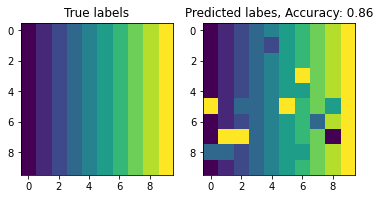

In [13]:
# Chosen parameters 
params_face_rec['var'] = 10000.0
params_face_rec['k'] = 5
params_face_rec['laplacian_regularization'] = 0.05
params_face_rec['laplacian_normalization'] = 'rw'

# Graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True,**params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()

print('Percentage of labeled images: ', round(100*np.sum(masked_labels>0)/len(labels),4), '%')
print("Accuracy = ", accuracy)

# Visualize true vs predicted labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.title('True labels')
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Predicted labes, Accuracy: {}".format(accuracy))
plt.show()

- **Second dataset: 50 images per person**

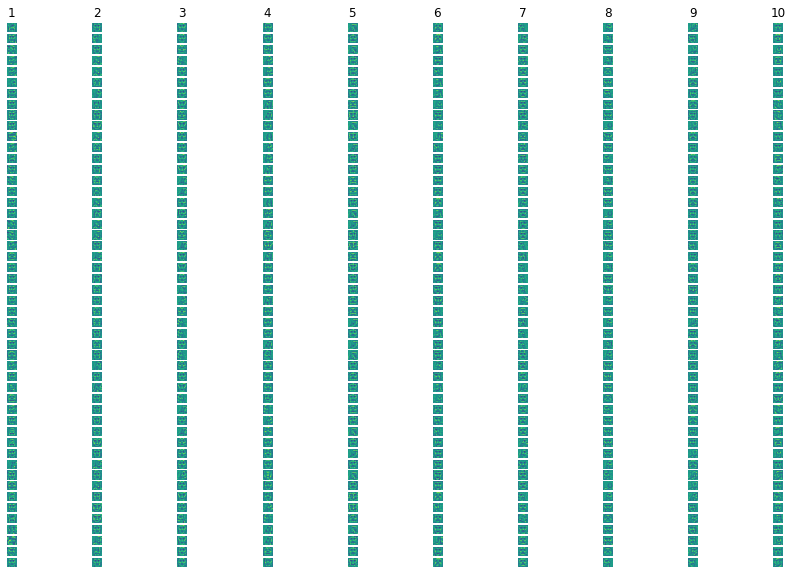

In [14]:
# 50 images per person
np.random.seed(456)  
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

Percentage of labeled images:  8.0 %
Accuracy =  0.718


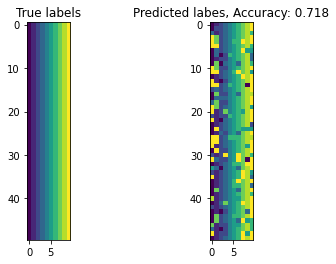

In [15]:
# Chosen parameters 
params_face_rec['var'] = 1000.0
params_face_rec['k'] = 7
params_face_rec['laplacian_regularization'] = 0.05
params_face_rec['laplacian_normalization'] = 'unn'

# Graph Laplacian
L = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a, f = compute_hfs(L, masked_labels_a, soft=True,per_class=True,**params_face_rec)
accuracy = np.equal(predicted_labels_a, labels_a).mean()

print('Percentage of labeled images: ', round(100*np.sum(masked_labels_a>0)/len(labels_a),4), '%')
print("Accuracy = ", accuracy)

# Visualize true vs predicted labels
plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.title('True labels')
plt.subplot(122)
plt.imshow(predicted_labels_a.reshape((-1, 10)))
plt.title("Predicted labes, Accuracy: {}".format(accuracy))
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

**Answer:** 

> - In this part, we used for training, $15$ images of **my face** and $15$ other images of **Selena Gomez** face. Then, we applied the online SSL algorithm. After tuning the parameters, we found that the best performance is obtained with $k = 15$, the Laplacian $L_{unn}$, a Laplacian regularization equal to $0.05$, $c_l = 0.9$ and $c_u = 0.1$. 
<br><br>
> - In this case, the algorithm is able to correctly classify the upcoming samples of both faces, either separately or in a combined way. The following figures show the performance of the algorithm. We can notice that this algorithm is able to classify well the faces with very high accuracy. However, we can also notice that the results are sometimes unstable when running the algorithm over a long period of time, which may be due to the small size of the training data set.

    - My face:
![](photo1.png)

    - Selena Gomez face: 
![](photo2.png)

    - Both faces: 
![](photo3.png)   

### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


**Answer:** 

> - Using the previous algorithm, we can notice that a new person appearing on the camera can be classified as one of the labels even if it is detected with lower score. Thus, we are inspired by this idea to assign people having lower scores to **unknown** label. To do so, we added a constraint after the calculation of the scores to assign the detection as **unknown** if the highest probability in the score vector is less than a threshold value, in this case we chose $0.85$. 
<br><br>
> - The first figure shows an example of **Taylor Swift** face detected as **unknown** with a score of $0.6975$. Likewise, the second figure shows my face detected with its correct label and **Taylor Swift** face detected as **unknown**. The algorithm is now able to distinguish faces it has already seen from new faces. 
<br><br>
> $\Longrightarrow$ We can conclude that the algorithm is now capable of classifying faces in both cases: seen and unseen faces. 

    - Unknown detected face: 
![](photo4.png)  

    - Unknown face + my face: 
![](photo5.png)  

In [16]:
import os
import sys
import cv2 as cv
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import distance
from helper_online_ssl import create_user_profile, online_face_recognition , online_face_recognition_adapted

In [17]:
"""
Define parameters for face recognition with HFS

"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 1.0
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = None
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = 0.9
params_online_ssl['c_u'] = 0.1

In [18]:
class IncrementalKCenters:
    
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):
        
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])

    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        
        """
        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            
            """                      
            # Number of centroids 
            nbr = self.centroids_distances.shape[0]
            
            # All nearest centroids: in ascending order
            idx_list = np.argsort(self.centroids_distances.ravel())
            
            # Extract the position of centroids 
            for idx in idx_list:
                c_1 = idx // nbr
                c_2 = idx % nbr
                
                # At least one of them is not in b 
                if (c_1 not in self.taboo) or (c_2 not in self.taboo):
                    break                    

            if c_1 in self.taboo:
                c_rep = c_1
                c_add = c_2
            
            elif c_2 in self.taboo:
                c_rep = c_2
                c_add = c_1
            
            elif self.V[c_2] <= self.V[c_1]:
                c_rep = c_1
                c_add = c_2
            
            else:
                c_rep = c_2
                c_add = c_1               

            """
            Update data structures: self.centroids and self.V
            
            """
            self.V[c_rep] += self.V[c_add]
            self.centroids[c_add, :] = face
            self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.
        Returns a prediction corresponding to self.last_face.
        
        """
        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        W_tilde = build_similarity_graph(self.centroids, 
                                       var=params_online_ssl['var'], 
                                       k=params_online_ssl['k'], 
                                       eps=params_online_ssl['eps'])
        
        W = V @ W_tilde @ V 
        L = build_laplacian(W, params_online_ssl['laplacian_normalization'])
        Q = L + params_online_ssl['laplacian_regularization']*np.eye(L.shape[0]) 

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)
    
        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1 
        label_scores = []
        
        for ii in range(num_classes):
            
            # Extract labels and scores 
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            
            # Check "unkown" detections 
            if np.max(f[self.last_face]) < 0.85 :
                label = "unknown"
          
            label_scores.append((label, score))
        
        return label_scores

In [19]:
# Construct datasets
create_user_profile('Eya Ghamgui')        
create_user_profile('Selena Gomez')

# Choose parameters 
params_online_ssl['k'] = 15
params_online_ssl['laplacian_regularization'] = 0.05

# Perform Online face recognition   
online_face_recognition(['Eya Ghamgui', 'Selena Gomez'], IncrementalKCenters, n_pictures=15)

Profile found with 15 images.
Profile found with 15 images.
Profile found with 15 images.
Profile found with 15 images.


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification
   

In [20]:
# Choose parameters 
params_online_ssl['k'] = 15
params_online_ssl['laplacian_regularization'] = 0.05

# Perform adaptative Online face recognition  
# I implemented this function in helper_online_ssl.py
online_face_recognition_adapted(['Eya Ghamgui', 'Selena Gomez'], IncrementalKCenters, n_pictures=15)

Profile found with 15 images.
Profile found with 15 images.


**Answer:** 

> - In this question, we will proceed as follows. First, we will save all the **unknown** faces detected as well as their indices in lists. If the number of **unknown** faces is greater than the number chosen as the best number of appearances (here $15$ pictures), we will start checking whether the last detected face has been seen enough times. In other words, the number of faces closest to it in terms of distance is greater than the best appearance number. In this case, we will create a new label **NewPerson** and add it to the list of labels. Then we will change all the $0$ classes corresponding to these faces with a new class that corresponds to **max(classes)+1**. Finally, we will remove these faces from the list of **unknown** faces and indices. The new class will be displayed by the algorithm on the newly detected face. 
<br><br>
> - The following figures show an example of previously detected **unknown** face but now classified as a **NewPerson**. From the third figure, this algorithm is now able to distinguish between the old labels and the newly created ones; in our case, between my face and Taylor Swift face (**NewPerson**).  

    - Unknown detected face: 
![](photo6.png)

    - Detect and add a new class "third class":
![](photo7.png)

    - New class detected + my face: 
![](photo8.png)

### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

#### <font color='red'> Required Libraries

In [21]:
import numpy as np 
from sklearn import svm 

# https://github.com/HugoooPerrin/semi-supervised-learning
from LapSVM import LapSVM 

# River Library for Online Learning
# https://github.com/online-ml/river
from river import metrics
from river import linear_model
from sklearn.semi_supervised import LabelSpreading
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from load_images import load_image_data_augmented, plot_image_data_augmented
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

#### <font color='red'> Generate datasets

In [22]:
# Generate faces images for only two persons (num_per = 2) (binary case)
np.random.seed(456)  
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image, number_masked=35, num_per=2)

# Train data
train_size = 80
X_train = images_a[:train_size]
y_train_labeled = labels_a[:train_size]
y_train = masked_labels_a[:train_size]

X = X_train[np.where(y_train != 0)]
XU = X_train[np.where(y_train == 0)]
y = y_train[np.where(y_train != 0)]
             
# Test data
X_test = images_a[train_size:]
y_test_labeled = labels_a[train_size:]

print('Number of training samples: ', X_train.shape[0])
print('Number of training labeled samples: ', X.shape[0])
print('Number of training unlabeled samples: ', XU.shape[0])
print('Number of testing samples: ', X_test.shape[0])

Number of training samples:  80
Number of training labeled samples:  55
Number of training unlabeled samples:  25
Number of testing samples:  20


**Comments:** 

> In this question, we generated a dataset of $2$ classes (**num_per = 2**). The data consists of faces of two different persons. Here, we chose $N=80$, $l=55$ and $u=25$ such that $N = l + u$. I modified the function that generates faces dataset to adjust the percentage of labeled and unlabeled faces by adding the parameter **number_masked**. 

#### <font color='red'>  First case: Supervised VS Semi-Supervised

In [23]:
print('- Supervised SVM trained on "l = 55" labeled samples:')

SVM = svm.SVC()
SVM.fit(X, y)
y_pred_test = SVM.predict(X_test)

print('    Supervised SVM accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test)* 100 , '%')
print('    Supervised SVM f1-score on test data:', f1_score(y_test_labeled, y_pred_test))
print('    Supervised SVM recall on test data:', recall_score(y_test_labeled, y_pred_test))
print('    Supervised SVM precision on test data:', precision_score(y_test_labeled, y_pred_test))
print()

###########################################################

print('- Supervised SVM trained on "N = 80" samples:')

SVM = svm.SVC()
SVM.fit(X_train, y_train_labeled)
y_pred_test = SVM.predict(X_test)

print('    Supervised SVM accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test)* 100 , '%')
print('    Supervised SVM f1-score on test data:', f1_score(y_test_labeled, y_pred_test))
print('    Supervised SVM recall on test data:', recall_score(y_test_labeled, y_pred_test))
print('    Supervised SVM precision on test data:', precision_score(y_test_labeled, y_pred_test))
print()

###########################################################

print('- Semi-Supervised LaplacianSVM:')

kernel = RBF(1.0)
n_neighbors = 10
lambda_k = 1
lambda_u = 0

lapSVM = LapSVM(n_neighbors, kernel, lambda_k, lambda_u)
lapSVM.fit(X, XU, y)
y_pred_test_lapSVM = lapSVM.predict(X_test) + 1

print('    LaplacianSVM accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test_lapSVM)* 100 , '%')
print('    LaplacianSVM f1-score on test data:', f1_score(y_test_labeled, y_pred_test_lapSVM))
print('    LaplacianSVM recall on test data:', recall_score(y_test_labeled, y_pred_test_lapSVM))
print('    LaplacianSVM precision on test data:', precision_score(y_test_labeled, y_pred_test_lapSVM))

- Supervised SVM trained on "l = 55" labeled samples:
    Supervised SVM accuracy on test data: 90.0 %
    Supervised SVM f1-score on test data: 0.9
    Supervised SVM recall on test data: 0.9
    Supervised SVM precision on test data: 0.9

- Supervised SVM trained on "N = 80" samples:
    Supervised SVM accuracy on test data: 95.0 %
    Supervised SVM f1-score on test data: 0.9473684210526316
    Supervised SVM recall on test data: 0.9
    Supervised SVM precision on test data: 1.0

- Semi-Supervised LaplacianSVM:
    LaplacianSVM accuracy on test data: 75.0 %
    LaplacianSVM f1-score on test data: 0.761904761904762
    LaplacianSVM recall on test data: 0.8
    LaplacianSVM precision on test data: 0.7272727272727273


> - In this question, we have chosen as Supervised classifier the **SVM classifier** and as Semi-Supervised classifier the **LaplacianSVM classifier**. We used the code implemented in https://github.com/HugoooPerrin/semi-supervised-learning
<br><br>
> - We trained the supervised SVM on both "all-train-dataset" and "labeled-train-dataset". The LaplacianSVM is performed using the **RBF** kernel with a parameter equal to $1$.
<br><br>
> - After training the three different classifiers, we found that the Supervised SVM is outperforming. Moreover, Supervised SVM performs better on test data when using "the whole train dataset" for training with an accuracy of $95 \%$. The LaplacianSVM is the one with the lowest performance with an accuracy of $75 \%$ on the test dataset. This result may be due to the nature of the data, which in this case faces images as the features are with high dimensional or perhaps the number of samples is not sufficient for the learning task. The choice of the parameters of the graph or the type of kernel (in this case, we chose the RBF kernel) may have also an impact on the performance.
<br><br>
$\Longrightarrow$ We can conclude that for this task: face recognition, the Supervised SVM is better than the Semi-Supervised LaplacianSVM.

#### <font color='red'> Second case: <br><br> 1) Transductive VS Inductive

In [24]:
print('- Transductive Semi-Supervised learning:')

# Chosen parameters 
params_face_rec['var'] = 1000.0
params_face_rec['k'] = 7
params_face_rec['laplacian_regularization'] = 0.05
params_face_rec['laplacian_normalization'] = 'unn'

# graph Laplacian
L = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a, f = compute_hfs(L, masked_labels_a, soft=True, **params_face_rec)

print('    Transductive Semi-Supervised accuracy on train data:', 
              accuracy_score(predicted_labels_a[:train_size], y_train_labeled)* 100 , '%')
print('    Transductive Semi-Supervised accuracy on test data:', 
              accuracy_score(predicted_labels_a[train_size:], y_test_labeled)* 100 , '%')

###########################################################

print()
print('- Inductive Semi-Supervised learning:')

kernel = RBF(1.0)
n_neighbors = 10
lambda_k = 1
lambda_u = 0

lapSVM = LapSVM(n_neighbors, kernel, lambda_k, lambda_u)
lapSVM.fit(X,XU,y)

y_pred_train_lapSVM = lapSVM.predict(X_train) + 1
y_pred_test_lapSVM = lapSVM.predict(X_test) + 1

print('    LaplacianSVM accuracy on train data:', accuracy_score(y_train_labeled, y_pred_train_lapSVM)* 100 , '%')
print('    LaplacianSVM accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test_lapSVM)* 100 , '%')

- Transductive Semi-Supervised learning:
    Transductive Semi-Supervised accuracy on train data: 97.5 %
    Transductive Semi-Supervised accuracy on test data: 95.0 %

- Inductive Semi-Supervised learning:
    LaplacianSVM accuracy on train data: 53.75 %
    LaplacianSVM accuracy on test data: 75.0 %


> - Inductive learning is nothing but the principle behind the Supervised machine learning algorithms where a model tries to build a relationship between the feature variables and target variable by examining the hidden patterns in the train data. The model is not exposed to the test data during the learning phase and is only provided with the training data for the learning purpose.
<br><br>
> - In transductive learning, both training and testing data sets are exposed to the model in the learning phase. The model tries to find any information about the pattern in the combined dataset (training + testing) and later uses this information for predicting the values of the unlabelled testing data points. 
<br><br>
> - To do so, we chose to work on the Semi-Supervised learning. For the transductive learning, we performed the HFS method. We used the same parameters as previous question and concatenated data (training and testing sets together). We constructed the laplacian using these images, then, we generated labels using the Soft HFS. The final prediction is the one for all the data samples of the inputs. We splited them apart for the training and testing data. We obtained very high accuracy on both traing and testing sets ($97.5 \%$ on training set and $95 \%$ on testing set). 
<br><br>
> - For the inductive learning, we used the LaplacianSVM method with the same kernel and parameters as the previous question. We applied this method on the training set only (combination between labeled and unlableed samples). We found that this algorithm is performing well on the testing data with an accuracy of $75 \%$. However, it is not able to give good results on the training set. 
<br><br>
> $\Longrightarrow$ We can conclude that the inductive method is able to generalize better on an unseen samples. Nevertheless, the transductive method is able to give better performance on the training data. 

#### <font color='red'> 2) Inductive VS Inductive

In [25]:
print('- Inductive LaplacianSVM learning:')

kernel = RBF(1.0)
n_neighbors = 10
lambda_k = 1
lambda_u = 0

lapSVM = LapSVM(n_neighbors, kernel, lambda_k, lambda_u)
lapSVM.fit(X,XU,y)

y_pred_train_lapSVM = lapSVM.predict(X_train) + 1
y_pred_test_lapSVM = lapSVM.predict(X_test) + 1

print('    LaplacianSVM accuracy on train data:', accuracy_score(y_train_labeled, y_pred_train_lapSVM)* 100 , '%')
print('    LaplacianSVM accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test_lapSVM)* 100 , '%')

###########################################################

print()
print('- Inductive LabelSpreading learning with RBF kernel:')

label_prop_model = LabelSpreading(kernel='rbf', gamma = 20)

y_prop_train = y_train - 1
label_prop_model.fit(X_train, y_prop_train)

y_pred_train = label_prop_model.predict(X_train) + 1
y_pred_test = label_prop_model.predict(X_test) + 1

print('    LabelSpreading accuracy on train data:', accuracy_score(y_train_labeled, y_pred_train)* 100 , '%')
print('    LabelSpreading accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test)* 100 , '%')

###########################################################

print()
print('- Inductive LabelSpreading learning with knn kernel:')

label_prop_model = LabelSpreading(kernel='knn', n_neighbors=10)

label_prop_model.fit(X_train, y_prop_train)

y_pred_train = label_prop_model.predict(X_train) + 1
y_pred_test = label_prop_model.predict(X_test) + 1

print('    LabelSpreading accuracy on train data:', accuracy_score(y_train_labeled, y_pred_train)* 100 , '%')
print('    LabelSpreading accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test)* 100 , '%')

- Inductive LaplacianSVM learning:
    LaplacianSVM accuracy on train data: 53.75 %
    LaplacianSVM accuracy on test data: 75.0 %

- Inductive LabelSpreading learning with RBF kernel:
    LabelSpreading accuracy on train data: 86.25 %
    LabelSpreading accuracy on test data: 55.00000000000001 %

- Inductive LabelSpreading learning with knn kernel:
    LabelSpreading accuracy on train data: 88.75 %
    LabelSpreading accuracy on test data: 80.0 %


> - In this part, we aim to compare the performances of different inductive methods (LaplacianSVM and LabelSpreading). For the second method, we used different kernels (RBF and k-nn) to study the impact of the type of the kernel on labels prediction. 
<br><br>
> - We found that the LabelSpreading method with a k-nn kernel is outperforming. We can say that for the LabelSpreading method, the k-nn kernel is much better than the RBF kernel at generalizing over unseen samples. Moreover, when we compare the LaplacianSVM and LabelSpreading, we can say that the LaplacianSVM does not perform well on train data but it is able to generalize well on unseen data, which is not the case for the LabelSpreading method using the RBF kernel. Nevertheless, this method gives close performance on training and testing datasets when using the k-nn kernel. 
<br><br>
> $\Longrightarrow$ We can conclude that each inductive Semi-Supervised method can provide different results when predicting the labels. Besides, the choice of the kernel plays an important part in improving the quality of the method's performance. 

#### <font color='red'> Third case: Supervised VS Semi-Supervised and Transductive VS Inductive

In [26]:
print('- Supervised SVM trained on "N = 80" samples:')

SVM = svm.SVC()
SVM.fit(X_train, y_train_labeled)

y_pred_train = SVM.predict(X_train)
y_pred_test = SVM.predict(X_test)

print('    Supervised SVM accuracy on train data:', accuracy_score(y_train_labeled, y_pred_train)* 100 , '%')
print('    Supervised SVM accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test)* 100 , '%')
print()

###########################################################

print('- Transductive Semi-Supervised learning:')

# Chosen parameters 
params_face_rec['var'] = 1000.0
params_face_rec['k'] = 7
params_face_rec['laplacian_regularization'] = 0.05
params_face_rec['laplacian_normalization'] = 'unn'

# graph Laplacian
L = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a, f = compute_hfs(L, masked_labels_a, soft=True, **params_face_rec)

print('    Transductive Semi-Supervised accuracy on train data:', 
              accuracy_score(predicted_labels_a[:train_size], y_train_labeled)* 100 , '%')
print('    Transductive Semi-Supervised accuracy on test data:', 
              accuracy_score(predicted_labels_a[train_size:], y_test_labeled)* 100 , '%')

###########################################################

print()
print('- Inductive Semi-Supervised learning:')

kernel = RBF(1.0)
n_neighbors = 10
lambda_k = 1
lambda_u = 0

lapSVM = LapSVM(n_neighbors, kernel, lambda_k, lambda_u)
lapSVM.fit(X,XU,y)

y_pred_train_lapSVM = lapSVM.predict(X_train) + 1
y_pred_test_lapSVM = lapSVM.predict(X_test) + 1

print('    LaplacianSVM accuracy on train data:', accuracy_score(y_train_labeled, y_pred_train_lapSVM)* 100 , '%')
print('    LaplacianSVM accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test_lapSVM)* 100 , '%')

- Supervised SVM trained on "N = 80" samples:
    Supervised SVM accuracy on train data: 100.0 %
    Supervised SVM accuracy on test data: 95.0 %

- Transductive Semi-Supervised learning:
    Transductive Semi-Supervised accuracy on train data: 97.5 %
    Transductive Semi-Supervised accuracy on test data: 95.0 %

- Inductive Semi-Supervised learning:
    LaplacianSVM accuracy on train data: 53.75 %
    LaplacianSVM accuracy on test data: 75.0 %


> - In this part, we can compare a Supervised learner (for example SVM) with Semi-Supervised learners (Inductive Semi-Supervised learner for example LaplacianSVM and Transductive Semi-Supervised learner for example HFS). Basically, Supervised classifiers use labeled training set to learn a model that seperate the classes. Nevertheless, the inductive Semi-Supervised learner uses labeled and unlableled samples to learn the model. 
<br><br> 
> - From these examples, we found that the Supervised learner is close in performance to the transductive Semi-Supervised learner. The only change is the performance on the training data set. The Supervised model gives a performance of $100 \%$ since it learns on all labeled samples. For the Semi-Supervised model, there are unlabeled samples in the dataset that the model needs to learn their patterns. On the other hand, the inductive Semi-Supervised learner uses only $l$ labeled samples and $u$ unlabeled samples. If we use the same $N$ labeled samples added to other unlabeled samples, it can help the model to better exploit the nature of the data and achieve better performance. 
<br><br>
> $\Longrightarrow$ From the above examples, we can conclude that the Supervised learner and the Semi-Supervised transductive learner are relatively close in terms of performance. 

#### <font color='red'> Fourth case: Batch VS Online

In [27]:
print('- Offline Supervised Logistic Regression:')

LR = LogisticRegression()
LR.fit(X_train, y_train_labeled)
y_pred_test = LR.predict(X_test)

print('    Supervised Logistic Regression accuracy on test data:', accuracy_score(y_test_labeled, y_pred_test) * 100 , '%')
print()

###########################################################

print('- Online Supervised Logistic Regression:')

LR = linear_model.LogisticRegression()
metric = metrics.Accuracy()

# Make the model learn
for i in range(X_train.shape[0]):
    x = dict(zip(np.arange(X_train.shape[1]), X_train[i]))
    label = y_train_labeled[i] == 2
    model = LR.learn_one(x, label)      
    
# Testing the model
for i in range(X_test.shape[0]):
    x = dict(zip(np.arange(X_test.shape[1]), X_test[i]))
    label = y_test_labeled[i] == 2
    
    # make a prediction
    y_pred = LR.predict_one(x)
    
    # update the metric
    metric = metric.update(label, y_pred)  

print('    ', metric)    

- Offline Supervised Logistic Regression:
    Supervised Logistic Regression accuracy on test data: 95.0 %

- Online Supervised Logistic Regression:
     Accuracy: 90.00%


> - In offline learning, data is accumulated over a period of time. After that, the models are trained with the data accumulated all at once. The model learns patterns from all collected images and then uses these patterns to predict new unseen samples.
<br><br>
> - In online learning, training is done incrementally by continuously feeding data as it arrives or in small groups. Each learning step is quick and inexpensive.
<br><br>
> - In this part, we trained a Supervised learner using all the training data at once, then we evaluated the model. The online Supervised classifier continuously learns $N$ images. Each time, the model learns new patterns from the upcoming image. We used in this part the module developed in python for the streaming task: **River** (https://github.com/online-ml/river)
<br><br>
> - With offline learning, we can generate a data model at once. However, online learning has the ability to adjust the classifier based on future samples. In our case, we obtained close performances between the two models with a small advantage for the offline learner. In fact, the size of the training data may be small, which leads to a decrease in the performance of the online learner, but for a larger data set, it would become more efficient to use it instead of the offline learner. One of the major drawbacks of online learning is that if it is fed with poor quality data, the model will have bad performance and the user will see the impact instantly.

#### <font color='red'> Fifth case: Exact VS Quantified

In [28]:
# Chosen parameters 
params_face_rec['var'] = 1000.0
params_face_rec['k'] = 7
params_face_rec['laplacian_regularization'] = 0.05
params_face_rec['laplacian_normalization'] = 'unn'

###########################################################

print('- Exact Semi-Supervised learner:')

# Graph Laplacian
L = build_laplacian_regularized(X_train, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
predicted_labels_a, f = compute_hfs(L, y_train, soft=True, **params_face_rec)

print('    Exact Semi-Supervised accuracy:', accuracy_score(predicted_labels_a, y_train_labeled)* 100 , '%')
print()

###########################################################

print('- Quantified Semi-Supervised learner:')

# Multiplicity matrix
np.random.seed(10)
V = np.ones(X_train.shape[0])
for x in range(30):
    i = np.random.choice(np.arange(X_train.shape[0]))
    j = X_train.shape[0] - i - 1
    V[i]+=1
    V[j]-=1  
V = np.diag(V)

# Build quantized graph and its regularized Laplacian
W_tilde = build_similarity_graph(X_train,
                                 var=params_online_ssl['var'], 
                                 k=params_online_ssl['k'], 
                                 eps=params_online_ssl['eps'])
W = V @ W_tilde @ V 
L = build_laplacian(W, params_online_ssl['laplacian_normalization'])
Q = L + params_online_ssl['laplacian_regularization']*np.eye(L.shape[0]) 

# Run HFS
predicted_labels_a, f = compute_hfs(Q, y_train, soft=True,**params_face_rec)

print('    Quantified Semi-Supervised accuracy:', accuracy_score(predicted_labels_a, y_train_labeled)* 100 , '%')

- Exact Semi-Supervised learner:
    Exact Semi-Supervised accuracy: 97.5 %

- Quantified Semi-Supervised learner:
    Quantified Semi-Supervised accuracy: 92.5 %


> - Graph quantification is the process of transforming a model into an equivalent representation that improves runtime efficiency. In contrast, it can often lead to a decrease in model performance.
<br><br>
> - In this part, we used the Semi-Supervised HFS method. In one hand, we used the exact Laplacian matrix of the graph and in a second hand, we used the quantified Laplacian matrix of the $N$ labled and unlabled training samples. In addition, we used the same parameters defined in previous questions. We can notice that the performance of the second model is slightly lower than the one of the first model. 
<br><br>
> $\Longrightarrow$ We can conclude that the performance of the quantified Semi-Supervised learner remains high while gaining in memory and computational resources. We can further exploit the beneficial side of this approach when we use larger dataset.

#### <font color='red'> Sixth case: Exact VS Quantified and Online VS Batch and Inductive VS Transductive

> In this part, we can use for online learning the same algorithm as the one used in part "3" (online_ssl) while varying the use of the quantized and exact Laplacian matrix. Then, we can study the performances of the two models on the $N$ faces revealed during the learning, and the $m$ unrevealed faces.